# **Monte Carlo Simulation**

In [104]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import eigh

In [105]:
def ensure_pos_def(cov):
    # ensure covariance is positive definite: add tiny jitter along diagonal if needed
    # returns adjusted cov
    eps = 1e-8
    # eigh for symmetric matrices
    vals, vecs = eigh(cov)
    min_eig = vals.min()
    if min_eig < eps:
        jitter = (eps - min_eig)
        cov = cov + np.eye(cov.shape[0]) * jitter
    return cov

In [106]:
# Normalize forward month names (keep as string for plotting)
fwd['Month'] = fwd['Month'].astype(str)

# Convert forward numeric columns
fwd['Peak'] = fwd['Peak'].astype(float)
fwd['Off Peak'] = fwd['Off Peak'].astype(float)

# Normalize forward month names (keep as string for plotting)
fwd['Month'] = fwd['Month'].astype(str)

# Convert forward numeric columns
fwd['Peak'] = fwd['Peak'].astype(float)
fwd['Off Peak'] = fwd['Off Peak'].astype(float)

In [107]:
# Fit means & covariances on (hub, basis)
def fit_joint(df, hub_col):
    arr = df[[hub_col, 'basis']].dropna().values
    mu = arr.mean(axis=0)
    cov = np.cov(arr, rowvar=False)
    cov = ensure_pos_def(cov)
    return mu, cov

## **Monte Carlo Implementation** 

### **Formulae used:**
1. Basis = Busbar−Hub
2. Fixed Price (P75) = Percentile(busbar_sim, 25)

In [108]:
def plot(result_df):
    # ---- Quick plots ----
    plt.figure(figsize=(12, 5))
    plt.plot(results_df['Month'], results_df['Forward_Peak'], 'o-', label='Forward Peak')
    plt.plot(results_df['Month'], results_df['Sim_Peak_Mean'], 'x--', label='Simulated Peak Mean')
    plt.plot(results_df['Month'], results_df['Forward_Off'], 'o-', label='Forward Off-Peak')
    plt.plot(results_df['Month'], results_df['Sim_Off_Mean'], 'x--', label='Simulated Off-Peak Mean')
    plt.xticks(rotation=45)
    plt.ylabel('Price ($/MWh)')
    plt.title('Forward vs Monte Carlo Simulated Monthly Busbar Prices (Peak & Off-Peak)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # ---- Print a short table to console ----
    print(results_df[['Month','Forward_Peak','Sim_Peak_Mean','Forward_Off','Sim_Off_Mean']])

In [109]:
def montecarlo(data, fwd, gen):
    # Calculate basis for existing data
    data['basis'] = data['RT Busbar'] - data['RT Hub']
    
    # Split historical data by peak/off-peak
    peak_hist = data[data["P/OP"] == 1]
    off_hist = data[data["P/OP"] == 0]
    
    # Calculating mu and covariance for peak & off peak
    mu_off, cov_off = fit_joint(off_hist, 'RT Hub')
    mu_peak, cov_peak = fit_joint(peak_hist, 'RT Hub')
    
    # Print fitted params
    print("Fitted historical stats:")
    print("Off-peak mu (hub,basis):", mu_off, "samples:", len(off_hist))
    print("Off-peak cov:\n", cov_off)
    print("Peak mu (hub,basis):", mu_peak, "samples:", len(peak_hist))
    print("Peak cov:\n", cov_peak)

    
    # ---- Monte carlo ----
    rng = np.random.default_rng(42)
    N_SIMS = 30000  # number of Monte Carlo runs
    PERCENT = 25
    total_gen = gen_pred['final_pred'].sum()
    # mean_gen = gen_pred.groupby([gen_pred['Date'].dt.year, gen_pred['Date'].dt.month])['final_pred']
    # print(gen_pred.groupby([gen_pred['Date'].dt.year, gen_pred['Date'].dt.month]).head(10))
    
    results = []
    for idx, row in fwd.iterrows():
        month_label = row['Month']
        fwd_peak = float(row['Peak'])
        fwd_off = float(row['Off Peak'])
        # gen = mean_gen.
    
        # --- Off-peak simulation (simulating hub & basis) ---
        sims_off = rng.multivariate_normal(mean=mu_off, cov=cov_off, size=N_SIMS)
        hub_hist_off = sims_off[:, 0]
        basis_sim_off = sims_off[:, 1]
    
        # recenter hub to forward off-peak
        hub_off_shifted = hub_hist_off - hub_hist_off.mean() + fwd_off
        busbar_off_sim = hub_off_shifted + basis_sim_off                        # Busbar calculation
    
        # monthly stats
        off_mean = busbar_off_sim.mean()
        off_std = busbar_off_sim.std()
        off_var75 = np.percentile(busbar_off_sim, PERCENT)
        off_cvar75 = busbar_off_sim[busbar_off_sim <= off_var75].mean()
    
        # --- Peak simulation (simulating hub and basis)---
        sims_peak = rng.multivariate_normal(mean=mu_peak, cov=cov_peak, size=N_SIMS)
        hub_hist_peak = sims_peak[:, 0]
        basis_sim_peak = sims_peak[:, 1]
    
        hub_peak_shifted = hub_hist_peak - hub_hist_peak.mean() + fwd_peak
        busbar_peak_sim = hub_peak_shifted + basis_sim_peak                    # Busbar calculation
    
        peak_mean = busbar_peak_sim.mean()
        peak_std = busbar_peak_sim.std()
        peak_var75 = np.percentile(busbar_peak_sim, PERCENT)
        peak_cvar75 = busbar_peak_sim[busbar_peak_sim <= peak_var75].mean

        # Revenue
        
        results.append({
            'Month': month_label,
            'Forward_Peak': fwd_peak,
            'Sim_Peak_Mean': peak_mean,
            'Sim_Peak_STD': peak_std,
            'Peak_VaR_75': peak_var75,
            'Peak_CVaR_75': peak_cvar75,
            'Forward_Off': fwd_off,
            'Sim_Off_Mean': off_mean,
            'Sim_Off_STD': off_std,
            'Off_VaR_75': off_var75,
            'Off_CVaR_75': off_cvar75
        })
    
        # var75 = value risk - “The worst price I might see with 25% probability.”
        # CVar75 = conditional value at risk - “If the worst 25% happens, the average price I’ll see.”
    
    results_df = pd.DataFrame(results)
    results_df.head()
    plot(results_df)

C:\Users\amalc\AppData\Local\Temp\ipykernel_15904\709543053.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv("../data/CAISO-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
C:\Users\amalc\AppData\Local\Temp\ipykernel_15904\709543053.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("../data/CAISO-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
C:\Users\amalc\AppData\Local\Temp\ipykernel_15904\709543053.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version

Fitted historical stats:
Off-peak mu (hub,basis): [59.90337445  0.30258772] samples: 10944
Off-peak cov:
 [[2287.1008321   -16.22098191]
 [ -16.22098191   16.56662754]]
Peak mu (hub,basis): [64.06576102 -0.30955239] samples: 13114
Peak cov:
 [[4594.83468169   36.70292009]
 [  36.70292009   99.53298587]]


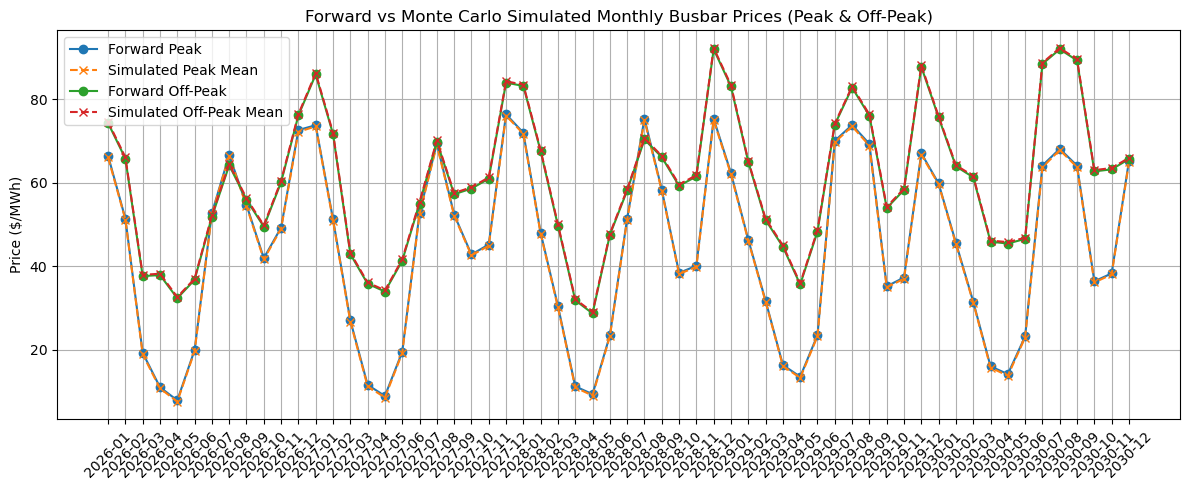

      Month  Forward_Peak  Sim_Peak_Mean  Forward_Off  Sim_Off_Mean
0   2026-01         66.49      66.098590        74.33     74.639946
1   2026-02         51.40      51.187706        65.81     66.126766
2   2026-03         19.21      18.864277        37.62     37.918249
3   2026-04         10.97      10.686745        37.87     38.189981
4   2026-05          7.81       7.521241        32.31     32.600597
5   2026-06         19.87      19.599775        36.72     36.990810
6   2026-07         52.73      52.449764        51.84     52.162264
7   2026-08         66.65      66.448033        64.20     64.487080
8   2026-09         54.69      54.386234        55.93     56.267763
9   2026-10         41.92      41.603372        49.48     49.797609
10  2026-11         49.26      48.993396        60.14     60.493878
11  2026-12         72.65      72.218412        76.16     76.447809
12  2027-01         73.81      73.523909        85.97     86.303938
13  2027-02         51.27      50.949151        

In [110]:
data = pd.read_csv("../data/CAISO-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
fwd = pd.read_csv("../data/CAISO-Forward-Prices.csv")
gen_pred = pd.read_csv("../data/CAISO-Future-Predictions.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
fwd['Month'] = pd.to_datetime(fwd['Month'], format='%b-%y').dt.to_period('M').astype(str)
# gen_pred.head()
# fwd.head()
montecarlo(data, fwd, gen_pred)

In [112]:
data = pd.read_csv("../data/ERCOT-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
fwd = pd.read_csv("../data/ERCOT-Forward-Prices.csv")
gen_pred = pd.read_csv("../data/ERCOT-Future-Predictions.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
fwd['Month'] = pd.to_datetime(fwd['Month'], format='%b-%y').dt.to_period('M').astype(str)
# gen_pred.head()
# fwd.head()
montecarlo(data, fwd, gen_pred)

C:\Users\amalc\AppData\Local\Temp\ipykernel_15904\3569674480.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv("../data/ERCOT-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
C:\Users\amalc\AppData\Local\Temp\ipykernel_15904\3569674480.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("../data/ERCOT-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
C:\Users\amalc\AppData\Local\Temp\ipykernel_15904\3569674480.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future vers

FileNotFoundError: [Errno 2] No such file or directory: '../data/ERCOT-Future-Predictions.csv'

In [113]:
data = pd.read_csv("../data/MISO-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
fwd = pd.read_csv("../data/MISO-Forward-Prices.csv")
gen_pred = pd.read_csv("../data/MISO-Future-Predictions.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
fwd['Month'] = pd.to_datetime(fwd['Month'], format='%b-%y').dt.to_period('M').astype(str)
# gen_pred.head()
# fwd.head()
montecarlo(data, fwd, gen_pred)

C:\Users\amalc\AppData\Local\Temp\ipykernel_15904\3592497022.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv("../data/MISO-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
C:\Users\amalc\AppData\Local\Temp\ipykernel_15904\3592497022.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("../data/MISO-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
C:\Users\amalc\AppData\Local\Temp\ipykernel_15904\3592497022.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future versio

FileNotFoundError: [Errno 2] No such file or directory: '../data/MISO-Future-Predictions.csv'